**Klein-Gordon equation**

Retyped by Theodoret Putra Agatho on 6 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/klein.gordon.html)

In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.3 MB/s eta 0:00:00


**Problem setup**

We will solve a Klein-Gordon equation:

\begin{align}
        \frac{\partial ^2 y}{\partial t^2} + \alpha \frac{\partial ^2 y}{\partial x^2} + \beta y + \gamma y^k = -x \text{cos} (t) + x^2 \text{cos} ^2 (t), x \in [-1, 1], t \in [0,10]
    \end{align}

with initial conditons

\begin{align}
        y(x, 0) = x, \frac{\partial y}{\partial t}(x, 0) = 0
    \end{align}

and Dirichlet boundary conditions

\begin{align}
        y(-1, t) = - \text{cos} (t), y(1,t) = \text{cos} (t)
    \end{align}

We also specify the following parameters for the equation:

\begin{align}
         \alpha = -1, \beta = 0, \gamma = 1, k = 2.
    \end{align}

The reference solution is $y(x, t) = x \text{cos} (t)$.

**Implementation**

This description goes through the implementation of a solver for the above described Klein-Gorden equation step-by-step.

First, the DeepXDE, NumPy, TensorFlow, Matplotlib, and SciPy modules are imported.

In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
from scipy.interpolate import griddata

We begin by defining computational geometries. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTIme` as follows

In [3]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the Klein-Gordon equation:

In [4]:
def pde(x, y):
  alpha, beta, gamma, k = -1, 0, 1, 2
  dy_tt = dde.grad.hessian(y, x, i=1, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  x, t = x[:, 0:1], x[:, 1:2]
  return (
      dy_tt
      + alpha * dy_xx
      + beta * y
      + gamma * (y ** k)
      + x * tf.cos(t)
      - (x ** 2) * (tf.cos(t) ** 2)
  )

The first argument to `pde` is a 2-dimensional vector where the first component(`x[:, 0:1]`) is the $x$-coordinate and the second component (`x[:, 1:2]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $y(x, t)$.

The reference solution `func` is then defined as the following.

In [5]:
def func(x):
  return x[:, 0:1] * np.cos(x[:, 1:2])

Next, we consider the boundary/initial conditions. `on_boundary` is chosen here to use the whole boundary of the computational domain as the boundary condition. We include the `geomtime` space/time geometry created above and `on_boundary` as the BC in the `DirichletBC` function of DeepXDE. We also define `IC` which is the initial condition for the Klein-Gordon equation, and we use the computational domain, initial function, and `on_initial` to specify the IC. Finally, we specify the initial condition for the first derivative of the $y$-coordinate with respect to the $t$-coordinate through the `OperatorBc` function of DeepXDE.

In [7]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
    lambda _, on_initial: on_initial,
)

Now, we have specified the geometry, PDE residual, and the boundary/initial conditions. We then define the TimePDE probblem as the following.

In [8]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=30000,
    num_boundary=1500,
    num_initial=1500,
    solution=func,
    num_test=6000,
)

The number 3000 is the number of training residual points sampled inside of the domain, and the number 1500 is the number of training points sampled on the boundary. We also include 1500 initial residual points for the initial conditions and 6000 points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 3 (i.e., 2 hidden layers) and width 40.

In [9]:
layer_size = [2] + [40] * 2 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate. We also implement a learning rate decay to reduce overfitting of the model.

In [11]:
model = dde.Model(data, net)
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], decay=("inverse time", 3000, 0.9)
)

Compiling model...
'compile' took 0.569111 s



We also compute the $L^2$ relative error as a metrics during training.

We then train the model for 20000 iterations.

In [12]:
model.train(iterations=20000)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.77e-01, 7.32e-01, 1.06e+00, 7.76e-03]    [2.32e-01, 7.32e-01, 1.06e+00, 7.76e-03]    [1.31e+00]    
1000      [1.14e-01, 2.11e-01, 4.33e-03, 1.07e-01]    [9.95e-02, 2.11e-01, 4.33e-03, 1.07e-01]    [5.89e-01]    
2000      [1.11e-02, 1.09e-01, 4.43e-03, 1.49e-01]    [9.25e-03, 1.09e-01, 4.43e-03, 1.49e-01]    [4.39e-01]    
3000      [3.92e-03, 1.04e-01, 4.65e-03, 1.51e-01]    [3.53e-03, 1.04e-01, 4.65e-03, 1.51e-01]    [4.33e-01]    
4000      [2.83e-03, 1.04e-01, 4.64e-03, 1.50e-01]    [2.63e-03, 1.04e-01, 4.64e-03, 1.50e-01]    [4.33e-01]    
5000      [2.43e-03, 1.04e-01, 4.61e-03, 1.50e-01]    [2.29e-03, 1.04e-01, 4.61e-03, 1.50e-01]    [4.33e-01]    
6000      [2.25e-03, 1.04e-01, 4.57e-03, 1.50e-01]    [2.16e-03, 1.04e-01, 4.57e-03, 1.50e-01]    [4.33e-01]    
7000      [2.14e-03, 1.04e-01, 4.53e-03, 1.49e-01]    [2.07e-03, 1.04e-01, 4.

(<deepxde.model.LossHistory at 0x7bb921554af0>,
 <deepxde.model.TrainState at 0x7bb921554a30>)

After we train the network with Adam, we compile again and continue to train the network using L-BFGS to achieve a smaller loss.

In [13]:
model.compile("L-BFGS", metrics=["l2 relative error"])
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.386912 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
20000     [1.63e-03, 1.05e-01, 4.27e-03, 1.47e-01]    [1.67e-03, 1.05e-01, 4.27e-03, 1.47e-01]    [4.35e-01]    
20041     [1.63e-03, 1.05e-01, 4.27e-03, 1.48e-01]    [1.67e-03, 1.05e-01, 4.27e-03, 1.48e-01]    [4.35e-01]    

Best model at step 20041:
  train loss: 2.58e-01
  test loss: 2.58e-01
  test metric: [4.35e-01]

'train' took 8.590567 s



We then save and plot the best trained result and loss history of the model.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


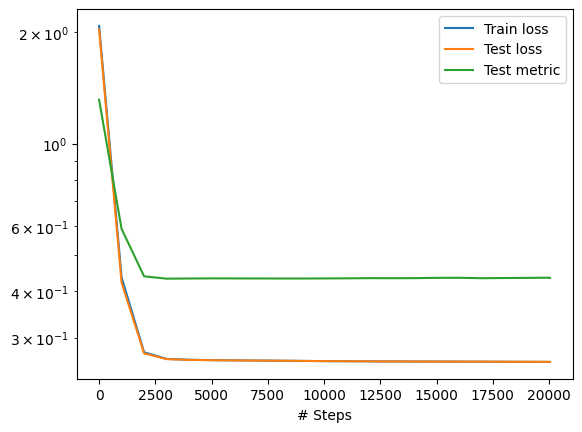

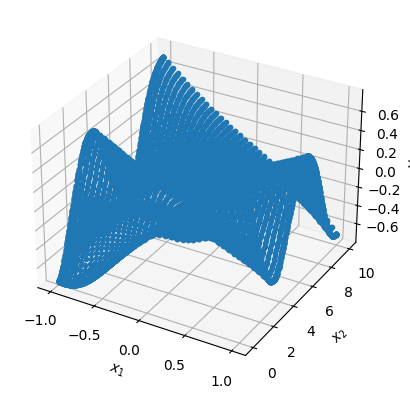

In [14]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Finally, we use the trained model to plot the predicted solution of the Klein-Gordon equation.

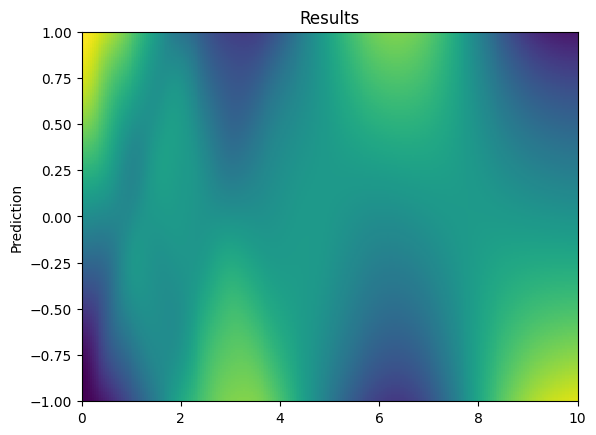

In [15]:
x = np.linspace(-1, 1, 256)
t = np.linspace(0, 10, 256)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star, operator=None)

v = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

fig, ax = plt.subplots()
ax.set_title("Results")
ax.set_ylabel("Prediction")
ax.imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[0, 10, -1, 1],
    origin="lower",
    aspect="auto"
)
plt.show()